In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from src.feature_engineering import add_cyclic_time_features
from src.utils import evaluate_model
from src.utils import run_logreg
from src.utils import tune_thresholds

SEED = 42

## Load and Preprocess Data

In [3]:
df = pd.read_csv('../data/creditcard.csv')

In [4]:
df_fe = df.copy()

# Add cyclic time features
df_fe = add_cyclic_time_features(df_fe)

# Log transform amount
df_fe['LogAmount'] = np.log1p(df_fe['Amount'])

# Drop raw Time and Amount
df_fe.drop(columns=['Time', 'Amount'], inplace=True)


In [5]:
v_features = [f'V{i}' for i in range(1, 29)]

# Base + LogAmount
features_1 = v_features + ['LogAmount']

# Base + LogAmount + Cyclic Time
features_2 = v_features + ['LogAmount', 'Hour_sin', 'Hour_cos']

## Picking a Preprocessing Scheme (LogisticRegression Baseline)

In [6]:
# Target
y = df_fe['Class']

# 1. LogAmount only (no scaling)
X1 = df_fe[features_1]
pr1 = run_logreg(X1, y, scale=False, desc="LogAmount Only (No Scaling)")

# 2. LogAmount only (with scaling)
pr2 = run_logreg(X1, y, scale=True, desc="LogAmount Only (With Scaling)")

# 3. LogAmount + Cyclic Time (no scaling)
X2 = df_fe[features_2]
pr3 = run_logreg(X2, y, scale=False, desc="LogAmount + Time (No Scaling)")

# 4. LogAmount + Cyclic Time (with scaling)
pr4 = run_logreg(X2, y, scale=True, desc="LogAmount + Time (With Scaling)")


Evaluation: LogAmount Only (No Scaling)
Confusion Matrix:
 [[56851    13]
 [   34    64]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9558 (reference)
PR AUC Score: 0.7406

Evaluation: LogAmount Only (With Scaling)
Confusion Matrix:
 [[56851    13]
 [   34    64]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9586 (reference)
PR AUC Score: 0.7376

Eva

## RandomForestClassifier

In [7]:
v_features = [f'V{i}' for i in range(1, 29)]
selected_features = v_features + ['LogAmount', 'Hour_sin', 'Hour_cos']
X = df_fe[selected_features]
y = df_fe['Class']

In [8]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=SEED)
rf.fit(X_train_scaled, y_train)

precision_rf, recall_rf, pr_auc_rf = evaluate_model(rf, X_test_scaled, y_test, model_name="Random Forest")


Evaluation: Random Forest
Confusion Matrix:
 [[56860     4]
 [   17    81]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9528 (reference)
PR AUC Score: 0.8673


## XGBoost

In [10]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # for imbalance
    eval_metric='logloss',
    random_state=SEED
)
xgb.fit(X_train_scaled, y_train)

precision_xgb, recall_xgb, pr_auc_xgb = evaluate_model(xgb, X_test_scaled, y_test, model_name="XGBoost")


Evaluation: XGBoost
Confusion Matrix:
 [[56809    55]
 [   13    85]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.87      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9822 (reference)
PR AUC Score: 0.8583


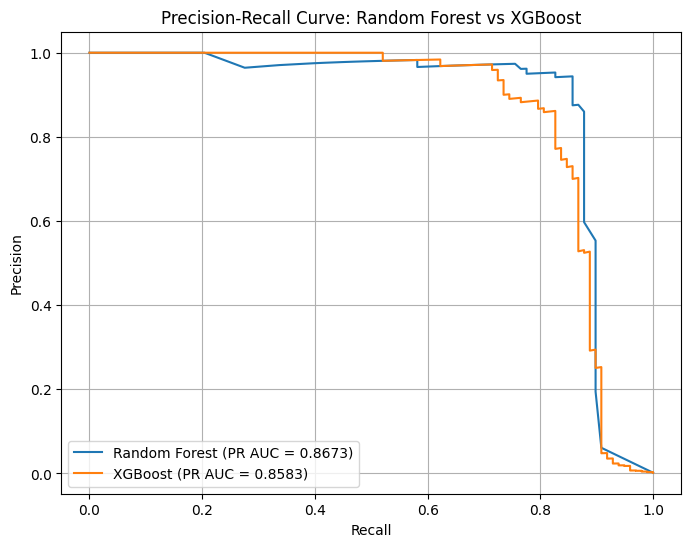

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (PR AUC = {pr_auc_rf:.4f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (PR AUC = {pr_auc_xgb:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Random Forest vs XGBoost')
plt.legend()
plt.grid()
plt.show()

## Tuning Inference Threshold

### XGBoost


XGBoost — Best F1 at threshold 0.95
Precision: 0.8617, Recall: 0.8265, F1: 0.8438


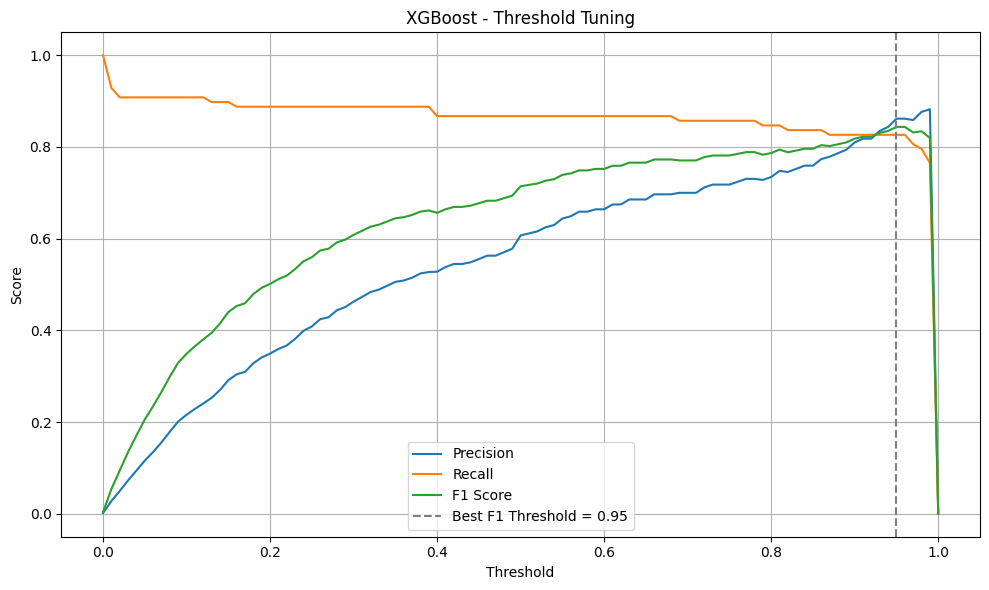

In [16]:
# Get predicted probabilities
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# Run threshold tuning
best_threshold_xgb = tune_thresholds(y_test, y_proba_xgb, model_name='XGBoost')

In [17]:
y_pred_xgb_custom = (y_proba_xgb >= best_threshold_xgb).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_custom))

Confusion Matrix:
 [[56851    13]
 [   17    81]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### Random Forest


Random Forest — Best F1 at threshold 0.41
Precision: 0.9438, Recall: 0.8571, F1: 0.8984


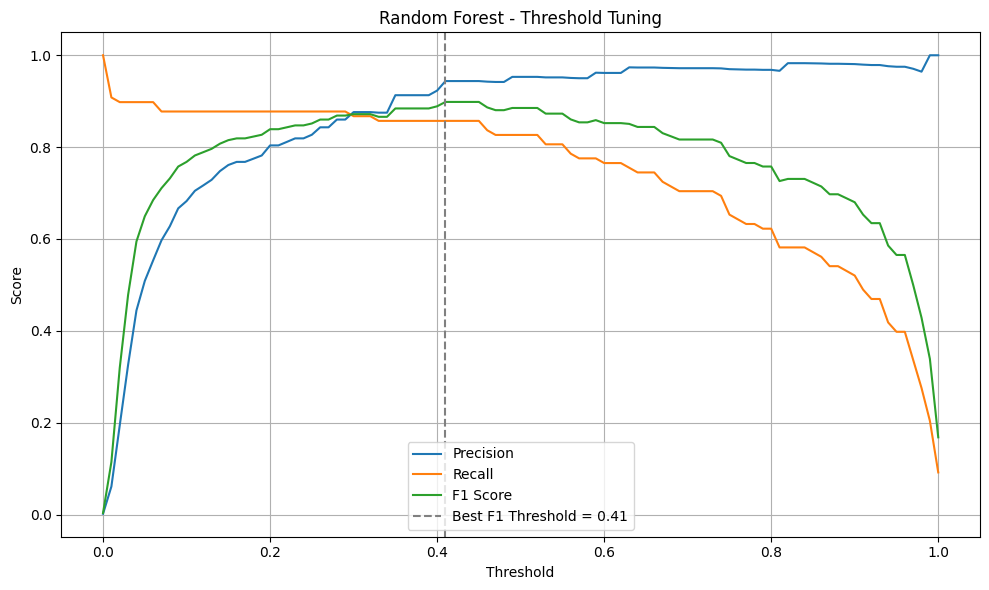

In [18]:
best_threshold_rf = tune_thresholds(y_test, rf.predict_proba(X_test_scaled)[:, 1], model_name="Random Forest")

In [19]:
y_pred_rf_custom = (rf.predict_proba(X_test_scaled)[:, 1] >= best_threshold_rf).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_custom))

Confusion Matrix:
 [[56859     5]
 [   14    84]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.86      0.90        98

    accuracy                           1.00     56962
   macro avg       0.97      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962

